# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [ ]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00


In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import mediapy as media

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [ ]:
import torch
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.conv(x)))



class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.downconv(x)))



class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.gelu(self.bn(self.upconv(x)))



class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.avg_pool(x)



class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.unflatten = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.unflatten(x)



class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))



class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock(self.downconv(x))



class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock(self.upconv(x))


## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        # encoder
        self.encoder1 = ConvBlock(in_channels, num_hiddens)           # ConvBlock to process the input channels
        self.encoder2 = DownBlock(num_hiddens, num_hiddens * 2)       # DownBlock to downsample and increase channels
        self.encoder3 = DownBlock(num_hiddens * 2, num_hiddens * 4)   # Another DownBlock

        # bottleneck
        self.flatten = Flatten()  # Flatten to reduce spatial dimensions to 1x1

        # eecoder
        self.unflatten = Unflatten(num_hiddens * 4)                   # Unflatten to expand from 1x1 to 7x7
        self.decoder1 = UpBlock(num_hiddens * 8, num_hiddens * 2)     # UpBlock to upsample (num_hiddens * 4 + num_hiddens * 4)
        self.decoder2 = UpBlock(num_hiddens * 4, num_hiddens)         # UpBlock to upsample (num_hiddens * 2 + num_hiddens * 2)

        self.adjust_channels = nn.Conv2d(num_hiddens * 2, num_hiddens, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)  # Final Conv layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        # encoder
        x1 = self.encoder1(x)  # First encoding block
        x2 = self.encoder2(x1)  # Downsampled encoding block
        x3 = self.encoder3(x2)  # Deeper downsampling

        # Bottleneck
        x_flat = self.flatten(x3)  # Flatten to 1x1

        # decoder
        x_up = self.unflatten(x_flat)        # Unflatten to 7x7
        x_up = torch.cat([x_up, x3], dim=1)  # Concatenate with encoder3 output (num_hiddens * 4 + num_hiddens * 4)
        x_up = self.decoder1(x_up)           # First decoding block
        x_up = torch.cat([x_up, x2], dim=1)  # Concatenate with encoder2 output (num_hiddens * 2 + num_hiddens * 2)
        x_up = self.decoder2(x_up)           # Second decoding block
        x_up = torch.cat([x_up, x1], dim=1)  # Concatenate with encoder1 output (num_hiddens + num_hiddens)

        x_up = self.adjust_channels(x_up)

        return self.final_conv(x_up)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

train_sigma = 0.5

def add_noise(x, sigma):
    noise = sigma * torch.randn_like(x)
    return x + noise

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# init
model = UnconditionalUNet(in_channels=1, num_hiddens=128).to('cuda')
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        noisy_images = add_noise(images, train_sigma).to('cuda')

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        # training loss
        epoch_loss += loss.item()
        train_losses.append(loss.item())

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

    torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')

    print(f'Average Epoch [{epoch+1}] Loss: {epoch_loss / len(train_loader):.4f}')

plt.plot(train_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


Epoch [1/5], Step [0/235], Loss: 0.1387
Epoch [1/5], Step [10/235], Loss: 0.0462
Epoch [1/5], Step [20/235], Loss: 0.0279
Epoch [1/5], Step [30/235], Loss: 0.0216
Epoch [1/5], Step [40/235], Loss: 0.0198
Epoch [1/5], Step [50/235], Loss: 0.0180
Epoch [1/5], Step [60/235], Loss: 0.0171
Epoch [1/5], Step [70/235], Loss: 0.0164
Epoch [1/5], Step [80/235], Loss: 0.0151
Epoch [1/5], Step [90/235], Loss: 0.0143
Epoch [1/5], Step [100/235], Loss: 0.0137
Epoch [1/5], Step [110/235], Loss: 0.0135
Epoch [1/5], Step [120/235], Loss: 0.0129


KeyboardInterrupt: 

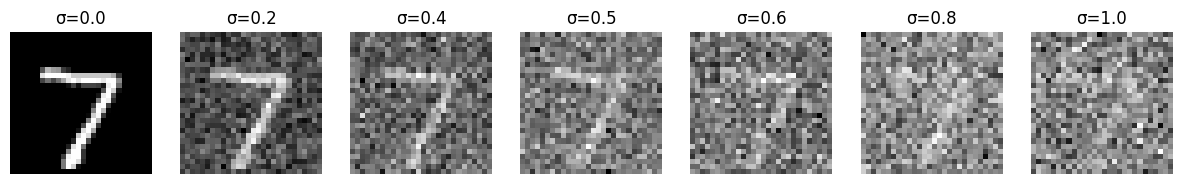

In [ ]:
sigma_values = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')

fig, axs = plt.subplots(1, len(sigma_values), figsize=(15, 3))
for i, sigma in enumerate(sigma_values):
    noisy_image = add_noise(sample_image, sigma)
    axs[i].imshow(noisy_image.cpu().squeeze(), cmap='gray')  # Remove extra dimensions
    axs[i].set_title(f'σ={sigma}')
    axs[i].axis('off')

plt.show()


In [ ]:
def visualize_denoising(model, test_loader, epoch, sigma):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images[:8].to('cuda')
    noisy_images = add_noise(images, sigma).to('cuda')

    with torch.no_grad():
        denoised_images = model(noisy_images)

    fig, axs = plt.subplots(3, 8, figsize=(15, 5))
    for i in range(8):
        axs[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title("Original")
        axs[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title(f"Noisy σ={sigma}")
        axs[2, i].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title("Denoised")

        for ax in axs[:, i]:
            ax.axis('off')
    plt.suptitle(f'Denoising Results after Epoch {epoch}')
    plt.show()

for epoch in [1, 5]:
    model.load_state_dict(torch.load(f'unet_epoch_{epoch}.pth'))
    visualize_denoising(model, test_loader, epoch, sigma=train_sigma)


<ipython-input-8-42d8d1d8435f>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'unet_epoch_{epoch}.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'unet_epoch_1.pth'

In [ ]:
for sigma in [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]:
    print(f"Testing with noise level σ={sigma}")
    visualize_denoising(model, test_loader, epoch=num_epochs, sigma=sigma)


# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
import torch
import torch.nn as nn


class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to("cuda")
        x = self.linear(x)
        x = self.gelu(x)
        return self.linear2(x)


class TimeConditionalUNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, num_hiddens: int):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # encoder
        self.encoder1 = ConvBlock(in_channels, num_hiddens)
        self.encoder2 = DownBlock(num_hiddens, num_hiddens)
        self.encoder3 = DownBlock(num_hiddens, num_hiddens * 2)

        # bottleneck
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        # decoder
        self.decoder1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.decoder2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.decoder3 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.output_conv = nn.Conv2d(
            num_hiddens, in_channels, kernel_size=3, stride=1, padding=1
        )

        # Time embedding layers
        self.time_fc1 = FCBlock(1, num_hiddens * 2)
        self.time_fc2 = FCBlock(1, num_hiddens)

    @staticmethod
    def apply_fc_block(obj: torch.Tensor, fc_block: nn.Module) -> torch.Tensor:
        obj = obj.unsqueeze(-1)  # (N,) -> (N, 1)
        obj = fc_block(obj)      # (N, 1) -> (N, 2D)
        obj = obj.unsqueeze(-1).unsqueeze(-1)  # (N, 2D) -> (N, 2D, 1, 1)
        return obj

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Input must have shape (N, C, 28, 28)."

        # encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x_bottleneck = self.flatten(x3)

        # bottleneck
        x_bottleneck = self.unflatten(x_bottleneck)
        t_emb1 = self.apply_fc_block(t, self.time_fc1)
        x_bottleneck = x_bottleneck + t_emb1

        # decoder
        x_dec1 = self.decoder1(torch.cat([x3, x_bottleneck], dim=1))
        t_emb2 = self.apply_fc_block(t, self.time_fc2)
        x_dec1 = x_dec1 + t_emb2

        x_dec2 = self.decoder2(torch.cat([x2, x_dec1], dim=1))
        x_dec3 = self.decoder3(torch.cat([x1, x_dec2], dim=1))
        output = self.output_conv(x_dec3)

        return output


## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """

    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "betas2": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
    }

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """
    Implements the forward pass of the DDPM training algorithm.

    Args:
        unet: Instance of TimeConditionalUNet.
        ddpm_schedule: Dictionary containing precomputed DDPM schedule values (e.g., alpha_bars).
        x_0: Input tensor of shape (N, C, H, W). Represents the original data.
        num_ts: Number of timesteps in the diffusion process.

    Returns:
        Diffusion loss (scalar tensor).
    """
    unet.train()

    t_idx = torch.randint(0, num_ts, (x_0.shape[0],), device=x_0.device)
    t = t_idx / num_ts

    # noisy input x_t
    eps = torch.randn_like(x_0)
    alpha_bar = ddpm_schedule['alpha_bars'][t_idx].view(-1, 1, 1, 1).to(x_0.device)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    # predict noise
    predicted_eps = unet(x_t, t)

    loss = torch.nn.functional.mse_loss(predicted_eps, eps)

    return loss


In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """
    Implements the DDPM sampling algorithm (Algorithm 2 in the DDPM paper)
    with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet model.
        ddpm_schedule: Dictionary containing precomputed DDPM schedule values.
        img_wh: Tuple (H, W) specifying the output image dimensions.
        num_ts: Number of timesteps in the reverse diffusion process.
        seed: Random seed for reproducibility.

    Returns:
        Final sample tensor of shape (N, C, H, W).
    """
    unet.eval()
    torch.manual_seed(seed)

    # init with noise
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1], device="cuda")

    # reverse diffusion process
    for t in reversed(range(1, num_ts + 1)):
        random_noise = torch.randn_like(x_t, device=x_t.device) if t > 1 else 0

        # predict noise with U-Net
        normalized_t = torch.tensor([t / num_ts], device=x_t.device)
        predicted_noise = unet(x_t, normalized_t)

        # get schedule params
        alpha_bar_t = ddpm_schedule['alpha_bars'][t]
        alpha_bar_t_minus_one = ddpm_schedule['alpha_bars'][t - 1] if t > 1 else 1.0
        alpha_t = ddpm_schedule['alphas'][t]
        beta_t = ddpm_schedule['betas2'][t]

        # x_0
        x_0 = (x_t - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)

        # x_{t-1}
        coeff1 = torch.sqrt(alpha_bar_t_minus_one) * beta_t
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus_one)
        coeff3 = torch.sqrt(beta_t)
        x_t = (coeff1 * x_0 + coeff2 * x_t) / (1 - alpha_bar_t) + coeff3 * random_noise

    return x_t


In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_loss(losses: list[float]) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Loss")
    plt.title("Training Losses")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

def img(image: torch.Tensor) -> torch.Tensor:
    try:
        return image.permute(1, 2, 0) / 2.0 + 0.5  # For (C, H, W)
    except RuntimeError:
        return image.transpose(1, 2, 0) / 2.0 + 0.5  # Alternative for NumPy arrays


In [ ]:
import random

def reset_random():
    seed = random.randint(0, 2**32 - 1)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sample_at_seed(model, seed, img_wh=(28,28), show_img=True):
    x_t = model.sample(img_wh, seed)
    if show_img:
        media.show_image(img(x_t[0]).cpu())
    return x_t

# print in rows of 10
def sample_at_random_seeds(model, img_wh=(28,28), n_rows=4, print_seed=False):
    for i in range(n_rows):
        reset_random()  # reset random seed
        row_imgs = []
        for j in range(10):
            seed = random.randint(0, 2**32 - 1)
            if print_seed: print(seed)
            x_t = sample_at_seed(model, seed, img_wh, show_img=False)
            row_imgs.append(img(x_t[0]).cpu())
        media.show_images(row_imgs)

In [ ]:
from tqdm import tqdm
import copy
import torch

def train_diffusion(
    training_set_non_loaded,
    num_epochs: int = 20,
    batch_size: int = 128,
    num_hiddens: int = 64,
    learning_rate: float = 1e-3
) -> tuple[torch.nn.Module, list[float], torch.nn.Module | None]:

    training_set = torch.utils.data.DataLoader(
        training_set_non_loaded,
        batch_size=batch_size,
        shuffle=True
    )

    # init
    unet = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=num_hiddens).to("cuda")
    model = DDPM(unet).to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=pow(0.1, 1.0 / num_epochs))

    model_epoch5 = None

    losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        for clean_images, _ in tqdm(training_set, desc=f"Epoch {epoch}/{num_epochs}"):

            # forward pass and compute loss
            clean_images = clean_images.to("cuda")
            optimizer.zero_grad()
            predicted_loss = model(clean_images)
            predicted_loss.backward()
            optimizer.step()
            losses.append(predicted_loss.item())

        scheduler.step()

        if epoch == 5:
            model_epoch5 = copy.deepcopy(model)

        if epoch in {5, num_epochs}:
            try:
                sample_at_random_seeds(model)
            except Exception as e:
                print(f"Visualization failed at epoch {epoch}: {e}")

        print(f"Epoch {epoch} complete. Last loss: {predicted_loss.item():.6f}")

    try:
        plot_loss(losses)
    except Exception as e:
        print(f"Error plotting loss curve: {e}")

    return model, losses, model_epoch5


100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Epoch 1 complete. last loss: 0.052139


100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Epoch 2 complete. last loss: 0.034062


100%|██████████| 469/469 [00:39<00:00, 11.91it/s]


Epoch 3 complete. last loss: 0.036664


100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Epoch 4 complete. last loss: 0.043030


100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 5 complete. last loss: 0.044204


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 6 complete. last loss: 0.034560


100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Epoch 7 complete. last loss: 0.031691


100%|██████████| 469/469 [00:39<00:00, 11.90it/s]


Epoch 8 complete. last loss: 0.033862


100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Epoch 9 complete. last loss: 0.035044


100%|██████████| 469/469 [00:39<00:00, 11.90it/s]


Epoch 10 complete. last loss: 0.031489


100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Epoch 11 complete. last loss: 0.026530


100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Epoch 12 complete. last loss: 0.028890


100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Epoch 13 complete. last loss: 0.028486


100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Epoch 14 complete. last loss: 0.031722


100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Epoch 15 complete. last loss: 0.030662


100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Epoch 16 complete. last loss: 0.028495


100%|██████████| 469/469 [00:39<00:00, 11.90it/s]


Epoch 17 complete. last loss: 0.032347


100%|██████████| 469/469 [00:39<00:00, 11.91it/s]


Epoch 18 complete. last loss: 0.031988


100%|██████████| 469/469 [00:39<00:00, 11.87it/s]


Epoch 19 complete. last loss: 0.026307


100%|██████████| 469/469 [00:39<00:00, 11.91it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 20 complete. last loss: 0.030125


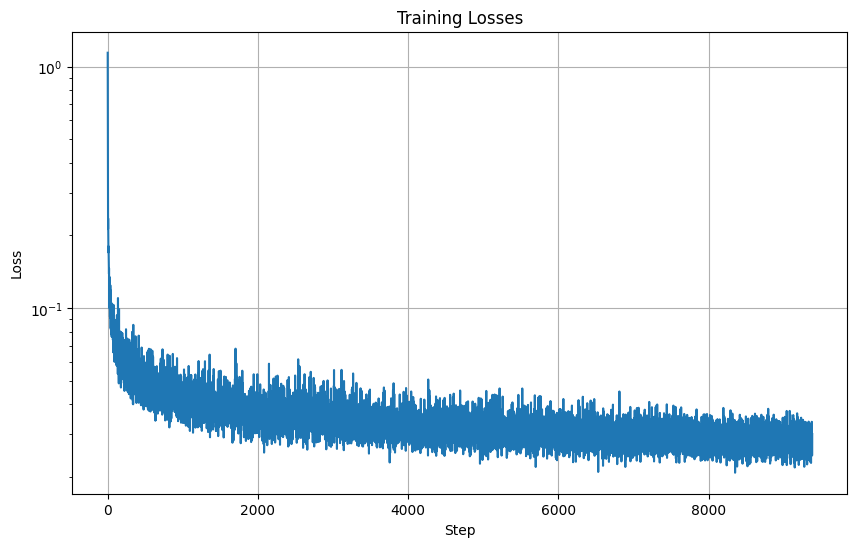

In [ ]:
model_diffusion, losses_diffusion, model_epoch5_diffusion = train_diffusion(training_set_non_loaded=train_dataset, num_epochs=20)

In [ ]:
import torch
import torch.nn as nn

class ClassConditionalUNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, num_hiddens: int):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        # Fully connected layers for time and class embeddings
        self.fc1_t = FCBlock(1, self.num_hiddens * 2)
        self.fc2_t = FCBlock(1, self.num_hiddens)
        self.fc1_c = FCBlock(self.num_classes, self.num_hiddens * 2)
        self.fc2_c = FCBlock(self.num_classes, self.num_hiddens)

    @staticmethod
    def apply_fc_block(input_tensor: torch.Tensor, fc_block: nn.Module) -> torch.Tensor:
        """
        Applies a fully connected block to the input tensor and reshapes the output.

        Args:
            input_tensor: Input tensor of shape (N,) or (N, num_classes).
            fc_block: Fully connected block.

        Returns:
            Output tensor reshaped to (N, 2D, 1, 1).
        """
        if input_tensor.dim() == 1:  # Handle (N,) shape
            input_tensor = input_tensor.unsqueeze(-1)
        output_tensor = fc_block(input_tensor)  # [N, 1] -> [N, 2D] or [N, num_classes] -> [N, 2D]
        return output_tensor.unsqueeze(-1).unsqueeze(-1)  # [N, 2D] -> [N, 2D, 1, 1]

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Forward pass of the ClassConditionalUNet.

        Args:
            x: Input tensor of shape (N, C, H, W).
            c: Condition tensor of shape (N, num_classes).
            t: Normalized time tensor of shape (N,).
            mask: Optional mask tensor of shape (N,). Masks out condition if mask == 0.

        Returns:
            Output tensor of shape (N, C, H, W).
        """
        # Apply masking if needed
        if mask is not None:
            c = c * mask.float().unsqueeze(-1).to(c.device)
        c = c.float().to(t.device)

        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = self.apply_fc_block(t, self.fc1_t)
        c1 = self.apply_fc_block(c, self.fc1_c)
        x5 = c1 * x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = self.apply_fc_block(t, self.fc2_t)
        c2 = self.apply_fc_block(c, self.fc2_c)
        x6 = c2 * x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)

        return x9


In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """
    Implements Algorithm 1 of DDPM paper for training the network.

    Args:
        unet: ClassConditionalUNet.
        ddpm_schedule: Dictionary with alpha_bars and other diffusion parameters.
        x_0: (N, C, H, W) clean input images.
        c: (N,) condition tensor (class labels).
        p_uncond: Probability of unconditioning.
        num_ts: Number of timesteps for the diffusion process.

    Returns:
        loss: MSE loss for predicted noise.
    """
    unet.train()

    def get_one_hot_vector(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
        one_hot = torch.zeros((labels.size(0), num_classes), device=labels.device)
        one_hot.scatter_(1, labels.unsqueeze(1), 1)
        return one_hot

    # random timestep for training
    t_idx = torch.randint(0, num_ts, (x_0.size(0),), device=x_0.device)
    alpha_bar = ddpm_schedule['alpha_bars'][t_idx].view(-1, 1, 1, 1)

    # diffuse input img to x_t
    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    # CFG dropout
    mask = torch.rand((x_0.size(0),), device=x_0.device) < p_uncond
    mask = mask.float().unsqueeze(-1)

    # prep inputs for UNet
    c_one_hot = get_one_hot_vector(c, unet.num_classes)
    predicted_eps = unet(x_t, c=c_one_hot, t=t_idx / num_ts, mask=mask)

    loss = torch.nn.functional.mse_loss(predicted_eps, eps)
    return loss


In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """
    Implements Algorithm 2 of DDPM paper for sampling with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet.
        ddpm_schedule: Dictionary with diffusion parameters.
        c: (N,) class labels as integers.
        img_wh: Tuple indicating output image dimensions (H, W).
        num_ts: Number of timesteps for the sampling process.
        guidance_scale: CFG scale for sampling.
        seed: Random seed for reproducibility.

    Returns:
        Final sampled image tensor of shape (N, C, H, W).
    """
    unet.eval()
    torch.manual_seed(seed)

    # prepare one-hot for conditional sampling
    if c.dim() == 1:  # If input is (N,)
        c_one_hot = torch.zeros((c.size(0), unet.num_classes), device=c.device)
        c_one_hot.scatter_(1, c.unsqueeze(1), 1)
    else:  # If input is already one-hot
        c_one_hot = c

    # random noise
    x_t = torch.randn((c.size(0), 1, *img_wh), device=c.device)

    # reverse diffusion
    for t in reversed(range(1, num_ts + 1)):
        t_normalized = torch.tensor([t / num_ts], device=c.device).repeat(c.size(0))
        random_noise = torch.randn_like(x_t) if t > 1 else 0

        # noise prediction w and w/out conditioning
        predicted_uncond_eps = unet(x_t, c=c_one_hot, t=t_normalized, mask=0)
        predicted_cond_eps = unet(x_t, c=c_one_hot, t=t_normalized)

        # combine predictions using CFG
        noise_est = predicted_uncond_eps + guidance_scale * (predicted_cond_eps - predicted_uncond_eps)

        alpha_bar_t = ddpm_schedule['alpha_bars'][t - 1]
        alpha_bar_t_prev = ddpm_schedule['alpha_bars'][t - 2] if t > 1 else torch.tensor(1.0, device=x_t.device)
        beta_t = ddpm_schedule['betas2'][t - 1]

        # x_0
        x_0 = (x_t - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)

        # x_{t-1}
        mean_x_t = (
            torch.sqrt(alpha_bar_t_prev) * beta_t * x_0 +
            torch.sqrt(alpha_bar_t) * (1 - alpha_bar_t_prev) * x_t
        ) / (1 - alpha_bar_t)
        x_t = mean_x_t + torch.sqrt(beta_t) * random_noise

    return x_t


In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:

        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ) -> torch.Tensor:
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )


def sample_at_seed_class_cond(
    model: DDPM,
    seed: int,
    img_wh=(28, 28),
    show_img=True,
    sampling_number=None
) -> torch.Tensor:

    x_t = model.sample(torch.tensor([sampling_number]), img_wh, seed=seed)
    if show_img:
        media.show_image(img(x_t[0]).cpu())
    return x_t


def sample_at_random_seeds_class_cond(
    model: DDPM,
    img_wh=(28, 28),
    n_rows=4,
    print_seed=False
):
    for _ in range(n_rows):
        reset_random()  # Reset the random seed
        row_imgs = []
        for label in range(10):  # Iterate over class labels (0 to 9)
            seed = random.randint(0, 10)
            if print_seed:
                print(f"Seed: {seed}")
            x_t = sample_at_seed_class_cond(
                model, seed, img_wh, show_img=False, sampling_number=label
            )
            row_imgs.append(img(x_t[0]).cpu())
        media.show_images(row_imgs)



In [ ]:
def train_diffusion_class(
    training_set_non_loaded,
    num_epochs=20,
    batch_size=128,
    num_hiddens=64,
    learning_rate=1e-3
):
    training_set = torch.utils.data.DataLoader(
        training_set_non_loaded, batch_size=batch_size, shuffle=True
    )

    # init
    unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=num_hiddens).to("cuda")
    model = DDPM(unet).to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=pow(0.1, 1.0 / num_epochs))

    losses = []
    model_epoch5 = None
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        for clean_images, digits in tqdm(training_set):
            clean_images, digits = clean_images.to("cuda"), digits.to("cuda")

            # loss and backprop
            optimizer.zero_grad()
            loss = model(clean_images, digits)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            epoch_loss += loss.item()

        scheduler.step()

        if epoch == 5:
            model_epoch5 = copy.deepcopy(model)

        if epoch in {5, num_epochs}:
            try:
                sample_at_random_seeds_class_cond(model)
            except Exception as e:
                print(f"Error generating samples: {e}")

        print(f"Epoch {epoch} complete. Average loss: {epoch_loss / len(training_set):.6f}")

    try:
        plot_loss(losses)
    except Exception as e:
        print(f"Error plotting loss curve: {e}")

    return model, losses, model_epoch5


100%|██████████| 469/469 [00:39<00:00, 11.77it/s]


Epoch 1 complete. average epoch loss: 0.069953


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 2 complete. average epoch loss: 0.042855


100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Epoch 3 complete. average epoch loss: 0.036927


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 4 complete. average epoch loss: 0.034545


100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 5 complete. average epoch loss: 0.032336


100%|██████████| 469/469 [00:39<00:00, 11.77it/s]


Epoch 6 complete. average epoch loss: 0.031408


100%|██████████| 469/469 [00:39<00:00, 11.84it/s]


Epoch 7 complete. average epoch loss: 0.030518


100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Epoch 8 complete. average epoch loss: 0.029640


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 9 complete. average epoch loss: 0.029209


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 10 complete. average epoch loss: 0.028434


100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Epoch 11 complete. average epoch loss: 0.027816


100%|██████████| 469/469 [00:39<00:00, 11.77it/s]


Epoch 12 complete. average epoch loss: 0.028227


100%|██████████| 469/469 [00:39<00:00, 11.84it/s]


Epoch 13 complete. average epoch loss: 0.027807


100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Epoch 14 complete. average epoch loss: 0.027651


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 15 complete. average epoch loss: 0.027176


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 16 complete. average epoch loss: 0.027029


100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Epoch 17 complete. average epoch loss: 0.027169


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 18 complete. average epoch loss: 0.026789


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 19 complete. average epoch loss: 0.026674


100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 20 complete. average epoch loss: 0.026539


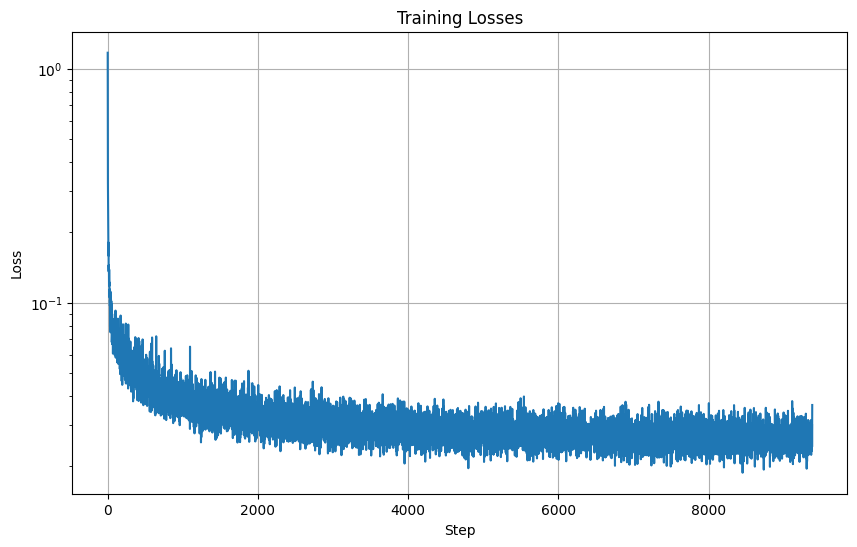

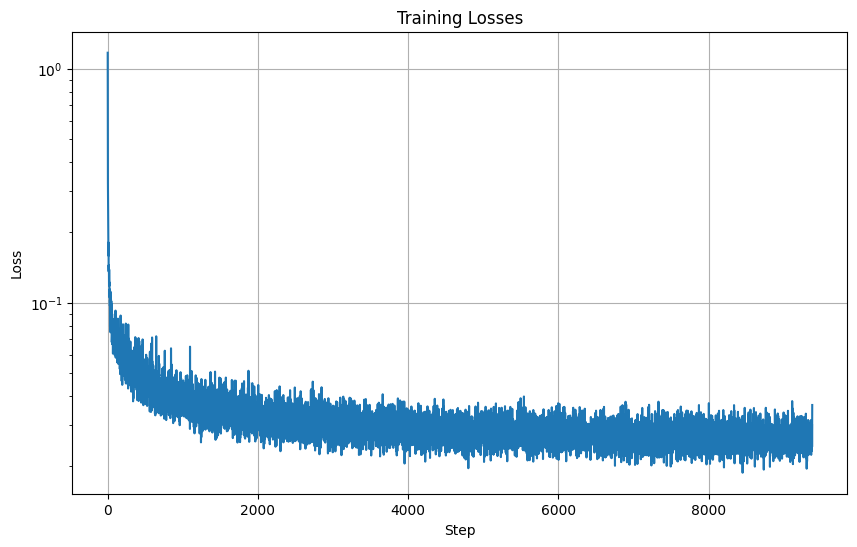

In [ ]:
class_conditional_model, class_conditional_losses, class_conditional_model_epoch5 = train_diffusion_class(training_set_non_loaded=train_dataset, num_epochs=20)
plot_loss(class_conditional_losses)

### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        # operational layers
        self.opr1 = ConvBlock(self.in_channels, self.num_hiddens)
        self.opr2 = DownBlock(self.num_hiddens, self.num_hiddens)
        self.opr3 = DownBlock(self.num_hiddens, self.num_hiddens * 2)
        self.opr4 = Flatten()
        self.opr5 = Unflatten(self.num_hiddens * 2)
        self.opr6 = UpBlock(self.num_hiddens * 4, self.num_hiddens)
        self.opr7 = UpBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr8 = ConvBlock(self.num_hiddens * 2, self.num_hiddens)
        self.opr9 = nn.Conv2d(self.num_hiddens, self.in_channels, kernel_size=3, stride=1, padding=1)

        self.fc1_t = FCBlock(1, self.num_hiddens * 2)
        self.fc2_t = FCBlock(1, self.num_hiddens)
        self.fc1_c = FCBlock(self.num_classes, self.num_hiddens * 2)
        self.fc2_c = FCBlock(self.num_classes, self.num_hiddens)

    # make t in the right shape (N, 2D, 1, 1)
    # dimensions are tricky here: [N] -> [N, 1] --fc--> [N, 2D] --> [N, 2D, 1, 1] --> [N, 2D, 7, 7]
    # or the second one to [N,D,14,14]
    def apply_fc_block(obj, fc_block):
        if (len(obj.size())) == 1: obj = obj.unsqueeze(-1) # [N] -> [N, 1]
        obj = fc_block(obj) # [N,1] -> [N,2D]
                            # otherwise [N, 10] -> [N, 2D]
        obj = obj.unsqueeze(-1).unsqueeze(-1) # [N, 2D] -> [N, 2D, 1, 1]
        return obj

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,num_classes) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        # apply masking if needed
        if mask == 0 or c is None:
            c = torch.zeros_like(c)
        c = c.float().to(t.device)

        # Encoder
        x1 = self.opr1(x)
        x2 = self.opr2(x1)
        x3 = self.opr3(x2)
        x4 = self.opr4(x3)

        # Decoder
        x_ = self.opr5(x4)
        t1 = ClassConditionalUNet.apply_fc_block(t, self.fc1_t)
        c1 = ClassConditionalUNet.apply_fc_block(c, self.fc1_c)
        x5 = c1 * x_ + t1

        x_ = self.opr6(torch.cat([x3, x5], dim=1))
        t2 = ClassConditionalUNet.apply_fc_block(t, self.fc2_t)
        c2 = ClassConditionalUNet.apply_fc_block(c, self.fc2_c)
        x6 = c2 * x_ + t2

        x7 = self.opr7(torch.cat([x2, x6], dim=1))
        x8 = self.opr8(torch.cat([x1, x7], dim=1))
        x9 = self.opr9(x8)
        return x9

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    num_classes = unet.num_classes
    def get_mnist_one_hot_vector(digits):
        one_hot = torch.zeros((digits.shape[0], num_classes)).to("cuda")
        # one_hot[i][digits[i]] = 1
        one_hot[torch.arange(one_hot.size(0)).to("cuda"), digits.long()] = 1
        return one_hot.float()

    def get_dropout_condition():
        choices = [True, False]
        return random.choices(choices, weights=[p_uncond, 1 - p_uncond])[0]

    # we sample a random t because we don't want the model to overfit based on sequential patterns, but also want it to learn the relationship between t and the noise prediction
    t_idx = torch.randint(0, num_ts, (x_0.shape[0],))
    t = t_idx

    # get x_t
    eps = torch.randn_like(x_0)
    alpha_bar = ddpm_schedule['alpha_bars'][t_idx].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to("cuda") # size N
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps

    # predict epsilon via unet
    # normalize t based on recommendation on writeup
    c_vector = get_mnist_one_hot_vector(c)
    mask = None if not get_dropout_condition() else 0
    predicted_eps = unet(x_t, c=c_vector, t=t / num_ts, mask=mask).float()

    # compute loss, perform gradient descent
    loss = torch.nn.functional.mse_loss(predicted_eps, eps)
    return loss

In [ ]:

@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        # c: (N,) int64 condition tensor. Only for class-conditional
        # c: (num_classes=10,) int64 condition tensor. Only for class-conditional NOTE: one hot vector
        c: (1,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, Ch, H, W) final sample.
        # (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    # make c into a one hot vector if it is only dimension
    if c.size() == torch.Size([1]):
        a = torch.zeros(unet.num_classes)
        a[c[0].long()] = 1
        c = a.unsqueeze(0)

    torch.manual_seed(seed)
    x_t = torch.randn(1, 1, img_wh[0], img_wh[1]).to("cuda")
    for t in reversed(range(1, num_ts)):
        random_noise = torch.randn_like(x_t).to("cuda") if t > 1 else 0

        # cfg noise
        predicted_unconditional_noise = unet(x_t, c=c, t=torch.Tensor([t / num_ts]), mask=0)
        predicted_conditional_noise = unet(x_t, c=c, t=torch.Tensor([t / num_ts])) # normalized t because that is how we trained the unet model.
        noise_est = predicted_unconditional_noise + guidance_scale * (predicted_conditional_noise - predicted_unconditional_noise)

        # alphas and betas
        alpha_bar_t_minus_one = ddpm_schedule['alpha_bars'][t - 1]
        alpha_bar_t = ddpm_schedule['alpha_bars'][t]
        alpha_t = ddpm_schedule['alphas'][t]
        beta_t = ddpm_schedule["betas2"][t]

        # calculate x_0
        division_factor = torch.sqrt(alpha_bar_t)
        coeff2 = torch.sqrt(1 - alpha_bar_t)
        x_0 = (x_t - coeff2 * noise_est) / division_factor

        # calculate x_{t-1}
        division_factor = 1 - alpha_bar_t
        coeff1 = torch.sqrt(alpha_bar_t_minus_one) * beta_t
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_minus_one)
        coeff3 = torch.sqrt(beta_t)
        x_t = (coeff1 * x_0 + coeff2 * x_t) / division_factor + coeff3 * random_noise


        # ========================

        # ========================
    return x_t

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Epoch 1 complete. average epoch loss: 0.071392


100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Epoch 2 complete. average epoch loss: 0.045161


100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Epoch 3 complete. average epoch loss: 0.038630


100%|██████████| 469/469 [00:39<00:00, 11.88it/s]


Epoch 4 complete. average epoch loss: 0.036046


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 5 complete. average epoch loss: 0.034490


100%|██████████| 469/469 [00:40<00:00, 11.70it/s]


Epoch 6 complete. average epoch loss: 0.033068


100%|██████████| 469/469 [00:39<00:00, 11.88it/s]


Epoch 7 complete. average epoch loss: 0.032019


100%|██████████| 469/469 [00:39<00:00, 11.87it/s]


Epoch 8 complete. average epoch loss: 0.031118


100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Epoch 9 complete. average epoch loss: 0.030394


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 10 complete. average epoch loss: 0.029352


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 11 complete. average epoch loss: 0.028380


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 12 complete. average epoch loss: 0.028867


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 13 complete. average epoch loss: 0.028215


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 14 complete. average epoch loss: 0.028045


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 15 complete. average epoch loss: 0.027515


100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Epoch 16 complete. average epoch loss: 0.027494


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Epoch 17 complete. average epoch loss: 0.027460


100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Epoch 18 complete. average epoch loss: 0.027159


100%|██████████| 469/469 [00:39<00:00, 11.88it/s]


Epoch 19 complete. average epoch loss: 0.026863


100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


,,,,,,,,,


Epoch 20 complete. average epoch loss: 0.026787


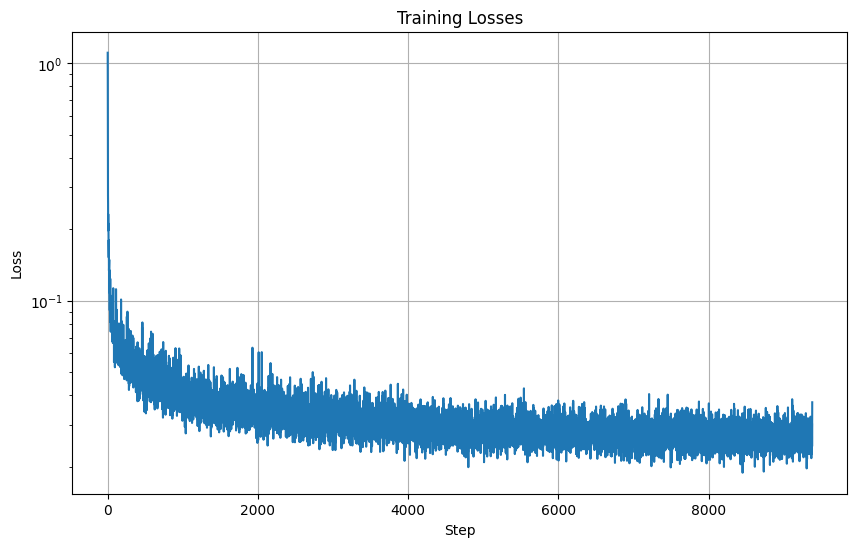

In [ ]:
class_conditional_model, class_conditional_losses, class_conditional_model_epoch5 = train_diffusion_class(training_set_non_loaded=train_dataset, num_epochs=20)
